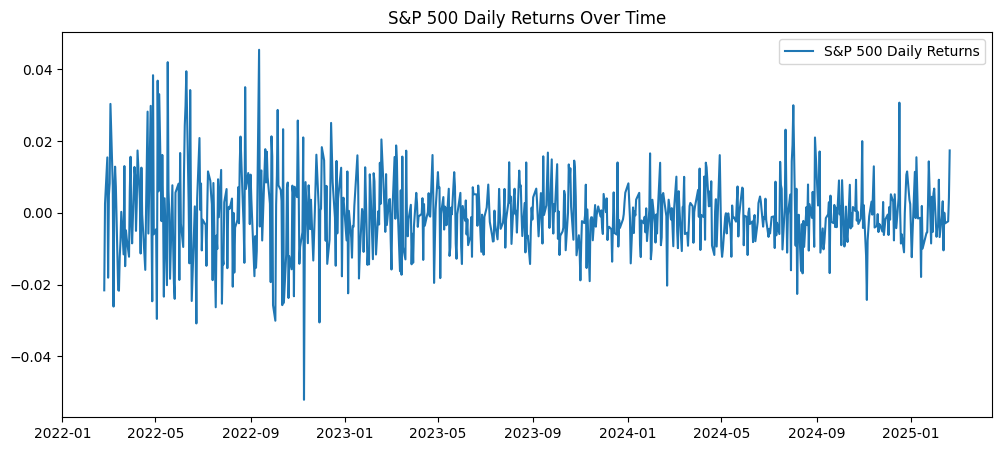

              Open     High     Low   Close      Volume    Return
date                                                             
2025-02-20  611.54  611.684  607.02  610.38  36554002.0  0.017402
2025-02-19  610.08  613.230  609.56  612.93  31011072.0  0.004178
2025-02-18  610.88  611.490  608.38  611.49  26749030.0 -0.002349
2025-02-14  609.94  610.990  609.07  609.70  26910448.0 -0.002927
2025-02-13  604.48  609.940  603.20  609.73  40921297.0  0.000049


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load SP500 returns data
df = pd.read_csv("sp500_data.csv", index_col=0, parse_dates=True)

# Calculate daily returns
df["Return"] = df["Close"].pct_change()

# Drop NaN values from return calculation
df = df.dropna()

# Plot returns
plt.figure(figsize=(12, 5))
plt.plot(df["Return"], label="S&P 500 Daily Returns")
plt.title("S&P 500 Daily Returns Over Time")
plt.legend()
plt.show()

# Show first few rows
print(df.head())



In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define number of lagged returns
n_lags = 6

# Create lagged feature matrix
for i in range(1, n_lags + 1):
    df[f"Return_Lag_{i}"] = df["Return"].shift(i)

# Compute technical indicators BEFORE feature selection
df["SMA_5"] = df["Close"].rolling(window=5).mean()  # 5-day Simple Moving Average
df["SMA_10"] = df["Close"].rolling(window=10).mean()  # 10-day SMA
df["Volatility"] = df["Return"].rolling(window=5).std()  # 5-day Rolling Std Dev

# Drop NaN values caused by shifting and rolling calculations
df = df.dropna()

# Select feature columns (lagged returns + technical indicators)
feature_columns = [f"Return_Lag_{i}" for i in range(1, n_lags + 1)] + ["SMA_5", "SMA_10", "Volatility"]
X = df[feature_columns].values
y = df["Return"].values

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normalize inputs (LSTMs work best with normalized data)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape y for scaling (required because it's 1D)
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

# Reshape data for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # (samples, time steps, features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)  # (samples, time steps, features)

# Print dataset shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")




X_train shape: (583, 9, 1)
X_test shape: (146, 9, 1)
y_train shape: (583,)
y_test shape: (146,)


Epoch 1/50


/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0768 - val_loss: 2.9233
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0685 - val_loss: 2.9007
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8980 - val_loss: 2.8944
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9866 - val_loss: 2.8993
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9736 - val_loss: 2.8875
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9753 - val_loss: 2.8819
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0541 - val_loss: 2.8939
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1468 - val_loss: 2.8803
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9217 - val_loss: 2.8742
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9491 - val_loss: 2.8752
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9442 - val_loss: 2.8615
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0509 - val_loss: 2.8744


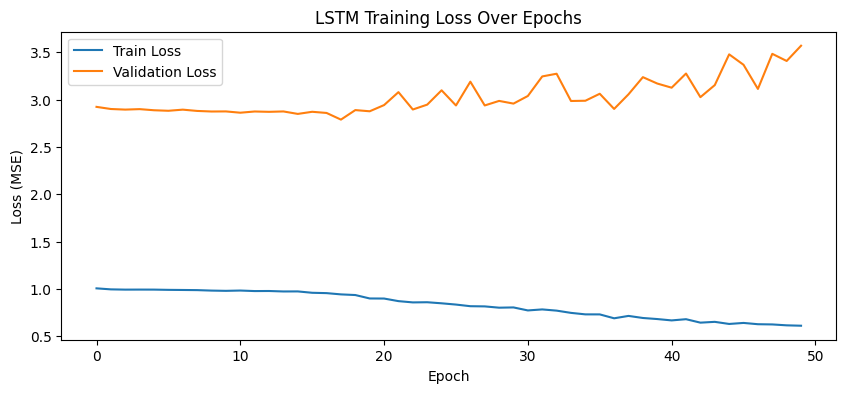

In [5]:
# Build the LSTM model
from tensorflow.keras.layers import Dropout

# Build a better LSTM model
model = Sequential([
    LSTM(64, activation="tanh", return_sequences=True, input_shape=(6, 1)),
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(32, activation="tanh"),
    Dense(1)  # Output layer (single neuron for return prediction)
])

# Compile the model
model.compile(optimizer="adam", loss="mse")

# Train the model again
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Plot training loss again
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("LSTM Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()



In [8]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict
y_pred = model.predict(X_test)

# Ensure `y_pred` is 2D before inverse transformation
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Ensure `y_test` is also reshaped properly for inverse transformation
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute performance metrics
mse = mean_squared_error(y_test_real, y_pred)
r2 = r2_score(y_test_real, y_pred)

print(f"New Test MSE: {mse:.6f}")
print(f"New Test R² Score: {r2:.6f}")



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
New Test MSE: 0.000309
New Test R² Score: -0.245642


In [9]:
import tensorflow as tf

# Convert test set to TensorFlow tensor
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)

# Function to compute gradients
def compute_gradients(model, X):
    with tf.GradientTape() as tape:
        tape.watch(X)
        predictions = model(X)
    gradients = tape.gradient(predictions, X)
    return gradients.numpy()

# Compute sensitivities (gradients)
sensitivities = compute_gradients(model, X_test_tf)

# Convert to DataFrame for better visualization
sensitivity_df = pd.DataFrame(sensitivities.reshape(sensitivities.shape[0], sensitivities.shape[1]),
                              columns=[f"Sensitivity_Lag_{i}" for i in range(1, sensitivities.shape[1] + 1)])

# Show first few rows
print(sensitivity_df.head())


   Sensitivity_Lag_1  Sensitivity_Lag_2  Sensitivity_Lag_3  Sensitivity_Lag_4  \
0           0.081893          -0.345790          -0.466725           0.040898   
1           0.152046           0.025022          -0.268968          -0.028487   
2          -0.124843           0.042656          -0.233028          -0.225620   
3           0.124526          -0.018228           0.072679          -0.070466   
4           0.100246           0.185461          -0.024966           0.073858   

   Sensitivity_Lag_5  Sensitivity_Lag_6  Sensitivity_Lag_7  Sensitivity_Lag_8  \
0          -0.572581          -0.436657          -0.459960          -0.288892   
1          -0.268373          -0.328749          -0.426781          -0.266999   
2          -0.234561           0.389674          -0.056126          -0.026654   
3           0.027802           0.011009           0.011666          -0.039923   
4           0.051815           0.085312           0.038223          -0.043300   

   Sensitivity_Lag_9  
0  

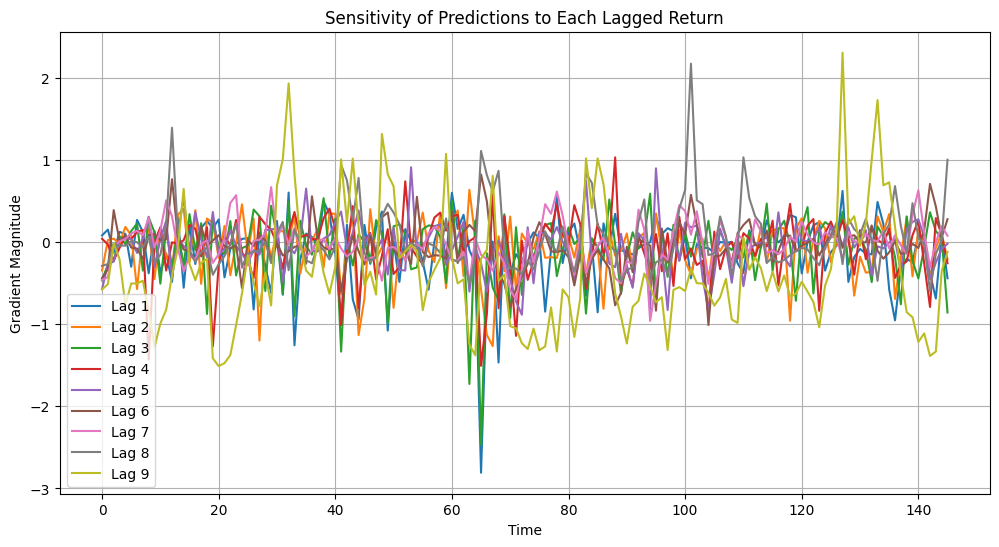

In [10]:
plt.figure(figsize=(12, 6))
for i in range(sensitivity_df.shape[1]):
    plt.plot(sensitivity_df.index, sensitivity_df.iloc[:, i], label=f"Lag {i+1}")

plt.title("Sensitivity of Predictions to Each Lagged Return")
plt.xlabel("Time")
plt.ylabel("Gradient Magnitude")
plt.legend()
plt.grid()
plt.show()


Below - if yfinance is used. 

In [ ]:
# Step 1: Fetch S&P 500 Data (Last 2 Years)

url = "https://www.investing.com/indices/us-spx-500-historical-data"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# Send GET request
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

# Find the table containing data
table = soup.find("table", {"class": "genTbl closedTbl historicalTbl"})

# Extract data
data = []
for row in table.find_all("tr")[1:]:  # Skipping header row
    cols = row.find_all("td")
    data.append([col.text.strip() for col in cols])

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Date", "Price", "Open", "High", "Low", "Change %"])

# Display DataFrame
print(df.head())


In [11]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.6f}")
print(f"Test R² Score: {r2:.6f}")




5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Test MSE: 0.000417
Test R² Score: -0.690494


In [ ]:
# -------------------------------------------
# Sensitivity Analysis using Vanilla Gradients
# -------------------------------------------
import tensorflow as tf

# Initialize list to store gradients for each test sample
sensitivities = []

# Loop through each sample in the test set
for i in range(len(X_test)):
    # Convert one sample to a tensor (shape: (1, 6, 1))
    sample = tf.convert_to_tensor(X_test[i:i+1], dtype=tf.float32)
    
    # Record the operations for automatic differentiation
    with tf.GradientTape() as tape:
        tape.watch(sample)
        # Get the prediction for this sample
        pred = model(sample)
    
    # Compute the gradient of the prediction with respect to the input sample
    grad = tape.gradient(pred, sample)
    sensitivities.append(grad.numpy())

# Convert sensitivities to a NumPy array: shape (num_samples, 6, 1)
sensitivities = np.array(sensitivities)

# Compute the average sensitivity over all test samples for each lag (axis=0)
avg_sensitivity = sensitivities.mean(axis=0).squeeze()  # shape becomes (6,)

print("Average Sensitivity for each lagged return (from Lag 1 to Lag 6):")
for i, sens in enumerate(avg_sensitivity, start=1):
    print(f"Lag {i}: {sens:.6f}")

# Plot the average sensitivity for each lagged input
plt.figure(figsize=(8, 4))
lags = np.arange(1, n_lags + 1)
plt.bar(lags, avg_sensitivity, color="skyblue")
plt.xlabel("Lagged Return (Lag Number)")
plt.ylabel("Average Sensitivity")
plt.title("Average Sensitivity of Model Output to Each Lagged Return")
plt.xticks(lags)
plt.show()

In [ ]:
# Step 2: Prepare Data for LSTM
lags = 6  # Using last 6 days to predict next day's return
X, y = [], []
for i in range(len(sp500) - lookback):
    window = sp500['Return'].iloc[i:i+lookback].values.flatten()  # Ensure it's a 1D array
    if len(window) == lookback:  # Ensure full 6-day window
        X.append(window)
        y.append(sp500['Return'].iloc[i+lookback])

X, y = np.array(X), np.array(y)  # Convert to NumPy arrays

print("X shape before reshaping:", X.shape)  # Should be (num_samples, 6)

# Now reshape for LSTM (LSTM expects 3D: [samples, time steps, features])
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Final X shape:", X.shape) 

In [ ]:
# Step 3: Define LSTM Model
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(lags, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Step 4: Train Model
model.fit(X, y, epochs=10, batch_size=16, verbose=1)

In [ ]:
# Step 5: Compute Vanilla Gradients
with tf.GradientTape() as tape:
    inputs = tf.convert_to_tensor(X, dtype=tf.float32)
    tape.watch(inputs)
    preds = model(inputs)
grads = tape.gradient(preds, inputs)

In [ ]:
# Step 6: Convert to Numpy and Visualize
grads_np = grads.numpy().squeeze()

def plot_gradients(grads_np):
    plt.figure(figsize=(10, 6))
    for i in range(grads_np.shape[1]):  # Loop through each lag
        plt.plot(grads_np[:, i], label=f'Lag {i+1}')
    plt.xlabel("Sample Index")
    plt.ylabel("Gradient Value")
    plt.title("LSTM Gradients for Each Lag")
    plt.legend()
    plt.show()

plot_gradients(grads_np)

In [ ]:
# Display some results
print("Sample Gradients for first few inputs:")
print(grads_np[:5])